In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib

In [3]:
# データセットの読み込み
DATASET_FILE = "simulated_dataset_v4.csv"
df = pd.read_csv(DATASET_FILE, header=None)
columns = [f"FFT_{i}" for i in range(len(df.columns) - 1)] + ["Label"]
df.columns = columns

In [6]:
label_counts = df["Label"].value_counts()
valid_labels = label_counts[label_counts >= 2].index
df = df[df["Label"].isin(valid_labels)]

In [7]:
# 特徴量とラベルの分離
X = df.drop(columns=["Label"]).values
y = df["Label"].values

# 特徴量の正規化
scaler = StandardScaler()
X = scaler.fit_transform(X)

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# LightGBM用のデータセット
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [10]:
params = {
    "objective": "binary",
    "metric": ["binary_error", "binary_logloss", "auc"],
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "verbose": -1,
}

# Early Stopping用のコールバック
callbacks = [
    lgb.early_stopping(stopping_rounds=10, verbose=True),
]

# モデルの学習
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, test_data],
    valid_names=["train", "test"],
    callbacks=callbacks,  # Early Stoppingの指定
)

# 最良のイテレーション数を取得
best_iteration = model.best_iteration
print(f"Best Iteration: {best_iteration}")

# テストデータでの評価
y_pred = model.predict(X_test, num_iteration=best_iteration)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_binary))

# モデルの保存
model.save_model("lightgbm_fault_model.txt")

# スケーラーの保存
joblib.dump(scaler, "scaler.pkl")

# データラベルの分布確認
print(df["Label"].value_counts())


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	train's binary_error: 0.0199115	train's binary_logloss: 0.261734	train's auc: 0.999173	test's binary_error: 0.0528634	test's binary_logloss: 0.320621	test's auc: 0.980202
Best Iteration: 21
Accuracy: 0.9471

Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.99      0.95       115
         1.0       0.99      0.90      0.94       112

    accuracy                           0.95       227
   macro avg       0.95      0.95      0.95       227
weighted avg       0.95      0.95      0.95       227

Label
0.0    571
1.0    560
Name: count, dtype: int64


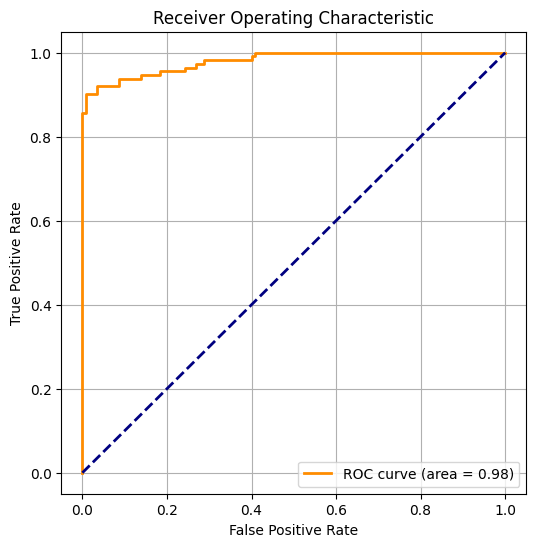

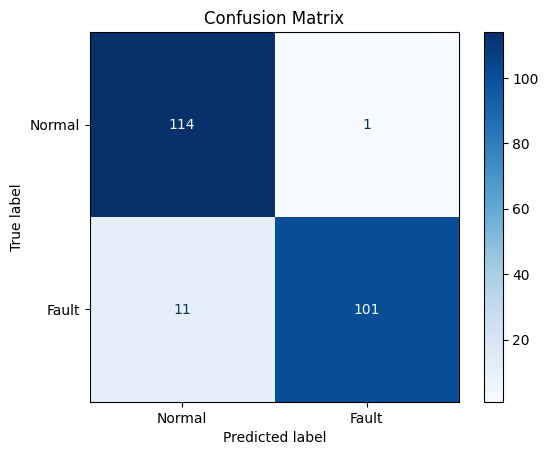

In [11]:
# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# 混同行列のプロット
cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Fault"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [16]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import classification_report

# モデルとスケーラーの読み込み
MODEL_FILE = "lightgbm_fault_model.txt"
SCALER_FILE = "scaler.pkl"
DATASET_FILE = "simulated_dataset_v4.csv"

# モデルとスケーラーをロード
model = lgb.Booster(model_file=MODEL_FILE)
scaler = joblib.load(SCALER_FILE)

def test_subset_from_dataset(dataset_file, label, n_samples, model, scaler):
    """
    データセットから指定したラベルのデータをN個抽出してテストする関数。

    Args:
        dataset_file (str): データセットファイルのパス。
        label (int): 抜き出すラベル（0: Normal, 1: Fault）。
        n_samples (int): 抜き出すサンプル数。
        model (lgb.Booster): 訓練済みのLightGBMモデル。
        scaler (StandardScaler): 訓練時に使用したスケーラー。

    Returns:
        None
    """
    # データセットの読み込み
    df = pd.read_csv(dataset_file, header=None)
    columns = [f"FFT_{i}" for i in range(len(df.columns) - 1)] + ["Label"]
    df.columns = columns

    # 指定ラベルのデータを抽出
    subset = df[df["Label"] == label].sample(n=n_samples, random_state=42)
    X_subset = subset.drop(columns=["Label"]).values
    y_subset = subset["Label"].values

    # 特徴量を正規化
    X_subset_normalized = scaler.transform(X_subset)

    # モデルで予測
    y_pred_prob = model.predict(X_subset_normalized)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # 結果表示
    # print("\nSelected Samples:")
    # print(subset.head())
    # print("\nPredictions:")
    # for i, (true_label, pred_label, prob) in enumerate(zip(y_subset, y_pred, y_pred_prob)):
    #     print(f"Sample {i}: True Label = {int(true_label)}, Prediction = {pred_label}, Probability = {prob:.3f}")

    # 評価指標
    print("\nClassification Report:")
    print(classification_report(y_subset, y_pred))

# 使用例
label_to_test = 0  # Normal
n_samples_to_test = 100

print(f"Testing {n_samples_to_test} samples with label {label_to_test} (Normal)")
test_subset_from_dataset(DATASET_FILE, label_to_test, n_samples_to_test, model, scaler)

label_to_test = 1  # Fault
n_samples_to_test = 100

print(f"\nTesting {n_samples_to_test} samples with label {label_to_test} (Fault)")
test_subset_from_dataset(DATASET_FILE, label_to_test, n_samples_to_test, model, scaler)


Testing 100 samples with label 0 (Normal)

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       100
         1.0       0.00      0.00      0.00         0

    accuracy                           0.99       100
   macro avg       0.50      0.49      0.50       100
weighted avg       1.00      0.99      0.99       100


Testing 100 samples with label 1 (Fault)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.97      0.98       100

    accuracy                           0.97       100
   macro avg       0.50      0.48      0.49       100
weighted avg       1.00      0.97      0.98       100



/Users/kinoshitayuki/py3_11_6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kinoshitayuki/py3_11_6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kinoshitayuki/py3_11_6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kinoshita

/Users/kinoshitayuki/py3_11_6/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


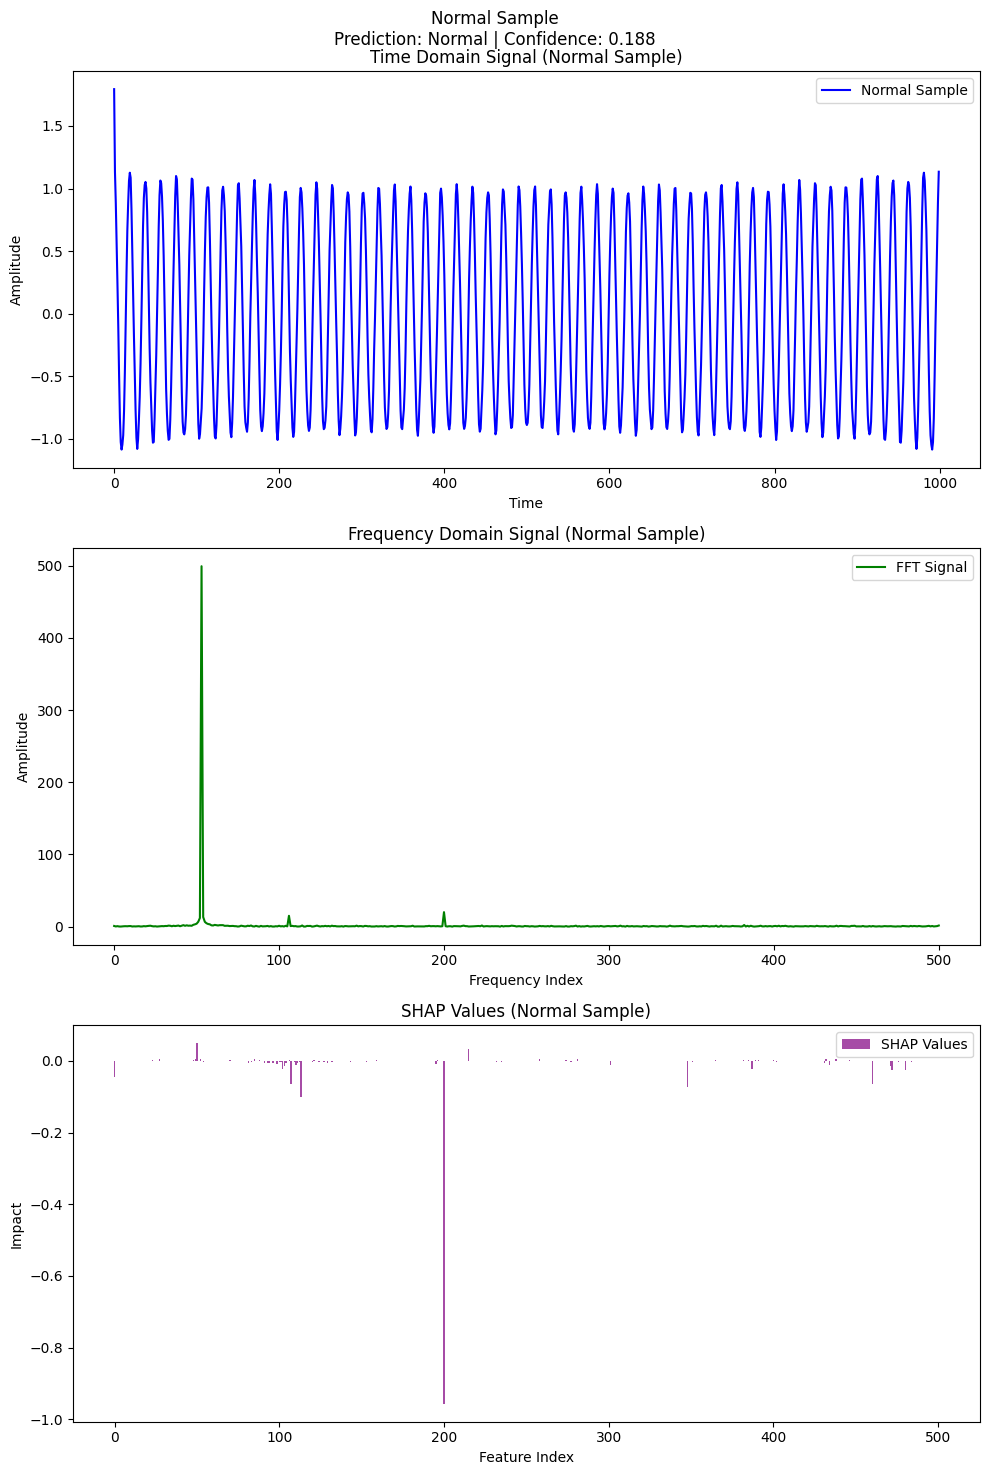

/Users/kinoshitayuki/py3_11_6/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


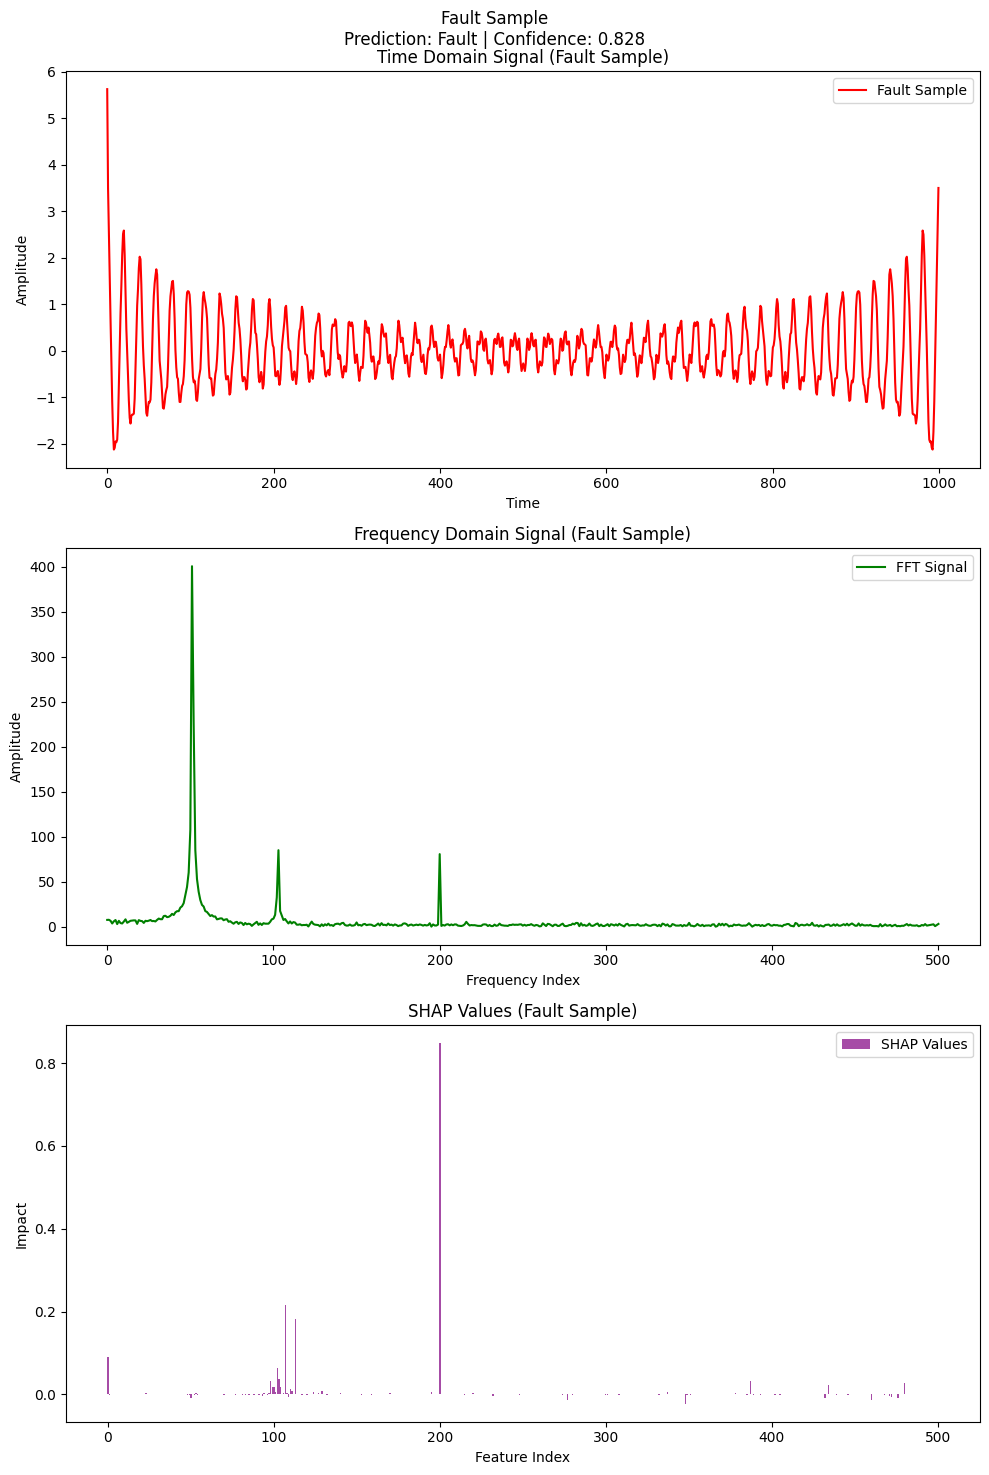

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import shap
import random
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

def visualize_decision_with_waveforms(model, scaler, X_test, y_test, feature_names):
    """
    テストデータからNormalとFaultを1つずつ選び、波形と判断事由を可視化

    Args:
        model: 学習済みLightGBMモデル
        scaler: スケーラー（StandardScaler）
        X_test: テスト特徴量
        y_test: テストラベル
        feature_names: 特徴量名（FFT成分の名前）
    """
    # NormalとFaultのサンプルをランダムに選択
    normal_index = random.choice([i for i, label in enumerate(y_test) if label == 0])
    fault_index = random.choice([i for i, label in enumerate(y_test) if label == 1])

    samples = [
        ("Normal", normal_index),
        ("Fault", fault_index)
    ]

    # SHAP Explainerの初期化
    explainer = shap.TreeExplainer(model)

    for label, index in samples:
        sample_feature = X_test[index].reshape(1, -1)
        original_feature = scaler.inverse_transform(sample_feature)[0]  # 正規化前の特徴量

        # SHAP値を計算
        shap_values = explainer.shap_values(sample_feature)
        shap_value = shap_values[0]

        # モデル予測
        prediction_prob = model.predict(sample_feature)[0]
        prediction = "Normal" if prediction_prob <= 0.5 else "Fault"

        # Time Domain Signal（波形）を復元
        time_signal = np.fft.irfft(original_feature, n=1000)

        # 可視化
        fig, axes = plt.subplots(3, 1, figsize=(10, 15))

        # 1. Time Domain Signal
        axes[0].plot(time_signal, label=f"{label} Sample", color="blue" if label == "Normal" else "red")
        axes[0].set_title(f"Time Domain Signal ({label} Sample)")
        axes[0].set_xlabel("Time")
        axes[0].set_ylabel("Amplitude")
        axes[0].legend()

        # 2. Frequency Domain Signal
        axes[1].plot(original_feature, label="FFT Signal", color="green")
        axes[1].set_title(f"Frequency Domain Signal ({label} Sample)")
        axes[1].set_xlabel("Frequency Index")
        axes[1].set_ylabel("Amplitude")
        axes[1].legend()

        # 3. SHAP Values
        axes[2].bar(range(len(shap_value)), shap_value, color="purple", alpha=0.7, label="SHAP Values")
        axes[2].set_title(f"SHAP Values ({label} Sample)")
        axes[2].set_xlabel("Feature Index")
        axes[2].set_ylabel("Impact")
        axes[2].legend()

        # 全体情報
        plt.suptitle(f"{label} Sample\nPrediction: {prediction} | Confidence: {prediction_prob:.3f}")
        plt.tight_layout()
        plt.show()

# 使用例
visualize_decision_with_waveforms(model, scaler, X_test, y_test, [f"FFT_{i}" for i in range(X_test.shape[1])])
